In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

# common python libraries
import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re
import json

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
from sklearn.manifold import TSNE

from scipy import stats

# data exchange with googlesheets
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# data exchange with sciencedata
import sddk

# language data modeling with gensim
from gensim import corpora
from gensim import models

# language data modeling with sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD  
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
### not neccessary for reading the data, just for exporting data and especially plots to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

# Import corpus

In [4]:
# import preprocessed data corpora from a public folder on sciencedata
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [6]:
len(c_hippocraticum)

52

In [7]:
c_hippocraticum = c_hippocraticum[c_hippocraticum["title"]!= "De diaeta"]

In [8]:
len(c_hippocraticum)

51

In [9]:
# function to extract all texts into one list of sentences
def get_flat_sentences(series):
    sentences_list = [sent for doc in series.tolist() for sent in doc]
    return sentences_list

In [10]:
# use the function
docs = get_flat_sentences(c_hippocraticum["lemmatized_sentences_repl"])

In [11]:
# number of sentences
len(docs) #(24456)

22982

In [12]:
# look at first 10 sentences
print(docs[:10])

[['ὁπόσος', 'ἐπιχειρέω', 'ἰητρικῆς', 'λέγω', 'γράφω', 'ὑπόθεσις', 'αὐτός', 'ὑποθέμενοι', 'λόγος', 'θερμός', 'ψυχρός', 'ὑγρός', 'ξηρός', 'ἄλλος', 'ἐθέλω', 'βραχύς', 'ἄγω', 'ἀρχή', 'αἰτία', 'ἄνθρωπος', 'νοῦσος', 'θάνατος', 'πᾶς', 'αὐτός', 'εἷς', 'ὑποθέμενοι', 'πολύς', 'λέγω', 'καταφανής', 'εἰμί', 'ἁμαρτάνω', 'ἄξιος', 'μέμφομαι', 'τέχνη', 'εἰμί', 'χράω', 'πᾶς', 'μέγας', 'τιμάω', 'ἀγαθός', 'χειροτέχνης', 'δημιουργός'], ['δημιουργός', 'φαῦλος', 'πολύς', 'διαφέροντες'], ['εἰμί', 'ἰατρικός', 'αὐτός', 'ἔσκεπτο', 'εὑρίσκω', 'μηδείς', 'εἰμί', 'πᾶς', 'ἄπειρος', 'ἀνεπιστήμων', 'εἰμί', 'τύχη', 'κάμνω', 'διοικεῖτο'], ['ἔχω', 'ἄλλος', 'τέχνη', 'δημιουργός', 'πολύς', 'διαφέρω', 'χείρ', 'γνώμη', 'ἰητρικῆς'], ['ἀξιόω', 'κενός', 'ὑπόθεσις', 'δέω', 'ἀφανέα', 'ἀπορεόμενα', 'ἀνάγκη', 'ἐπιχειρέω', 'λέγω', 'ὑπόθεσις', 'χράω', 'οἷος', 'μετέωρος', 'γῆ'], ['τὶς', 'λέγω', 'γιγνώσκω', 'ἔχω', 'λέγω', 'ἀκούω', 'δῆλος', 'εἰμί', 'ἀληθής', 'εἰμί'], ['χρή', 'ἀνενέγκαντα', 'οἶδα', 'σαφής'], ['ἰατρικός', 'πᾶς', 'ὑπάρχω', 

# Matrices & vectors with sklearn

In [13]:
# build gensim dictionary on the basis of whole works
lemmata = c_hippocraticum["lemmata_repl"].tolist()
dictionary = corpora.Dictionary(lemmata)
# words in at least 5 works
# (in tuple with the number of sentences in which they appear)
dictionary_tup = [(len([doc for doc in docs if dictionary[word_id] in doc]), dictionary[word_id]) for word_id in dictionary if dictionary.dfs[word_id] >= 5]
#n=2000 # n sorted words with highest frequency
vocabulary = [tup[1] for tup in sorted(dictionary_tup, reverse=True)] #[:n]]
doc_freq = [tup[0] for tup in sorted(dictionary_tup, reverse=True)] #[:n]]

In [14]:
len(vocabulary)

1925

In [15]:
sorted(dictionary_tup, reverse=True)[:10]

[(3173, 'εἰμί'),
 (2727, 'γίγνομαι'),
 (2218, 'οὗτος'),
 (1999, 'πολύς'),
 (1659, 'ἔχω'),
 (1165, 'ἄλλος'),
 (1045, 'ποιέω'),
 (999, 'σῶμα'),
 (966, 'χρή'),
 (955, 'αὐτός')]

In [17]:
# check whether key_words are in vocabulary
key_words = ['πόνο*', 'ὀδύν*', 'ἄλγ*', 'λύπ*']
for word in key_words:
    if word in vocabulary:
        print(word)

πόνο*
ὀδύν*
ἄλγ*
λύπ*


In [18]:
# check first 10 words in the vocabulary
vocabulary[:10]

['εἰμί',
 'γίγνομαι',
 'οὗτος',
 'πολύς',
 'ἔχω',
 'ἄλλος',
 'ποιέω',
 'σῶμα',
 'χρή',
 'αὐτός']

In [19]:
# check first sentence
docs[0]

['ὁπόσος',
 'ἐπιχειρέω',
 'ἰητρικῆς',
 'λέγω',
 'γράφω',
 'ὑπόθεσις',
 'αὐτός',
 'ὑποθέμενοι',
 'λόγος',
 'θερμός',
 'ψυχρός',
 'ὑγρός',
 'ξηρός',
 'ἄλλος',
 'ἐθέλω',
 'βραχύς',
 'ἄγω',
 'ἀρχή',
 'αἰτία',
 'ἄνθρωπος',
 'νοῦσος',
 'θάνατος',
 'πᾶς',
 'αὐτός',
 'εἷς',
 'ὑποθέμενοι',
 'πολύς',
 'λέγω',
 'καταφανής',
 'εἰμί',
 'ἁμαρτάνω',
 'ἄξιος',
 'μέμφομαι',
 'τέχνη',
 'εἰμί',
 'χράω',
 'πᾶς',
 'μέγας',
 'τιμάω',
 'ἀγαθός',
 'χειροτέχνης',
 'δημιουργός']

In [20]:
# SIMPLE TEST
# (by default, countvectorizers does some undesirable preprocessing (e.g. removes *....))
test_corpus =  [['δῆμος*', 'Ἀθηναῖος','φαίνω','Ἕλλην', 'φαίνω'], ['δοκέω','οὗτος','τέχνη','ἐμός']]
vec_bow = CountVectorizer(lowercase=False, token_pattern=r"\w+\*?") #vocabulary=vocabulary, token_pattern=r".?\w+\*?") #, #strip_accents=None, encoding="utf-8") #, token_pattern=r"\*?\w+\*?")
bow = vec_bow.fit_transform([" ".join(list(set(sentence))) for sentence in test_corpus]) ### run the model
vec_bow.get_feature_names()

['δοκέω', 'δῆμος*', 'οὗτος', 'τέχνη', 'φαίνω', 'Ἀθηναῖος', 'ἐμός', 'Ἕλλην']

In [21]:
# we create CountVectorizor model with our predefined vocabulary
# we are explict about prepreprocessing of the textual data
vec_bow = CountVectorizer(vocabulary=vocabulary, lowercase=False, token_pattern=r"\w+\*?") #vocabulary=vocabulary, token_pattern=r".?\w+\*?") #, #strip_accents=None, encoding="utf-8") #, token_pattern=r"\*?\w+\*?")
# we fit our sentences to the model
# -> we create a raw document-term matrix:
# notice that we calculate only unique instances of words within sentences 
# (that makes more straightforward an interpretation in terms of probability)
bow = vec_bow.fit_transform([" ".join(list(set(sentence))) for sentence in docs])

# by multiplication, we create a word-word co-occurrence matrix:
cooc  = bow.T * bow

# we use previously calculated frequencies to fill in the diagonal:
cooc.setdiag(doc_freq) 
# transform it into a dataframe
# all counts (diagonal) and co-occurrences are weighted by the number of documents
cooc_df = pd.DataFrame(cooc.todense() / len(docs), columns=vocabulary, index=vocabulary) # / len(docs)
cooc_df

/home/kasev/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,0.138065,0.019537,0.018580,0.016665,0.013924,0.010878,0.006918,0.009399,0.008877,0.009225,...,0.000087,0.000044,0.000000,0.000174,0.000000,0.000131,0.000087,0.000131,0.000131,0.000044
γίγνομαι,0.019537,0.118658,0.016752,0.016404,0.009616,0.008137,0.004482,0.009964,0.003481,0.007136,...,0.000087,0.000044,0.000087,0.000000,0.000044,0.000000,0.000044,0.000000,0.000000,0.000087
οὗτος,0.018580,0.016752,0.096510,0.011226,0.009007,0.006831,0.007441,0.004569,0.005483,0.004351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000044,0.000000,0.000044,0.000000,0.000044
πολύς,0.016665,0.016404,0.011226,0.086981,0.010095,0.007049,0.004482,0.006831,0.004525,0.004743,...,0.000000,0.000000,0.000044,0.000000,0.000000,0.000044,0.000044,0.000044,0.000000,0.000044
ἔχω,0.013924,0.009616,0.009007,0.010095,0.072187,0.006048,0.003263,0.006135,0.005352,0.004482,...,0.000000,0.000087,0.000000,0.000044,0.000000,0.000044,0.000000,0.000000,0.000087,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.000131,0.000000,0.000044,0.000044,0.000044,0.000044,0.000000,0.000087,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000000
διαχωρέῃ,0.000087,0.000044,0.000000,0.000044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000
δεόμενον,0.000131,0.000000,0.000044,0.000044,0.000000,0.000000,0.000000,0.000044,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000,0.000000
γυμνός,0.000131,0.000000,0.000000,0.000000,0.000087,0.000044,0.000000,0.000000,0.000044,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000


Thus, we have a word-word co-occurrence table with co-occurrences weighted by the number of sentences, i.e. potential events of co-occurrences. That makes an interpretation in terms of probability very straightforward.

In [22]:
# now we transform the co-occurrences into PMI3

pmi_rows_list = []
for column in cooc_df.columns:
    freq_a = cooc_df.at[column, column]
    pmi_row = []
    for term in cooc_df.index:
        freq_ab = cooc_df.at[column, term]
        if freq_ab > 0:
            freq_ab = freq_ab **3
            freq_b = cooc_df.at[term, term]
            pmi2 = math.log(freq_ab / (freq_a * freq_b))
        else:
            pmi2 = None
        pmi_row.append(pmi2)
    pmi_rows_list.append(pmi_row)

In [23]:
pmi_matrix = pd.DataFrame(pmi_rows_list, columns=vocabulary, index=vocabulary)

In [24]:
pmi_matrix_df = pd.DataFrame(pmi_matrix)
pmi_matrix_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,-1.980034,-7.694788,-7.638908,-7.861197,-8.213907,-8.600993,-9.849959,-8.885819,-9.023703,-8.896852,...,-17.634896,-19.714337,NaN,-15.555454,NaN,-16.418500,-17.634896,-16.418500,-16.418500,-19.714337
γίγνομαι,-7.694788,-2.131509,-7.798055,-7.757091,-9.172906,-9.320574,-11.001009,-8.559013,-11.680508,-9.515536,...,-17.483420,-19.562862,-17.483420,NaN,-19.562862,NaN,-19.562862,NaN,NaN,-17.483420
οὗτος,-7.638908,-7.798055,-2.338105,-8.688351,-9.162642,-9.638567,-9.273609,-10.691701,-10.111146,-10.793029,...,NaN,NaN,NaN,NaN,NaN,-19.356266,NaN,-19.356266,NaN,-19.356266
πολύς,-7.861197,-7.757091,-8.688351,-2.442064,-8.716627,-9.440556,-10.690454,-9.380886,-10.582860,-10.430537,...,NaN,NaN,-19.252307,NaN,NaN,-19.252307,-19.252307,-19.252307,NaN,-19.252307
ἔχω,-8.213907,-9.172906,-9.162642,-8.716627,-2.628496,-9.713491,-11.455745,-9.516912,-9.893048,-10.413961,...,NaN,-16.986433,NaN,-19.065875,NaN,-19.065875,NaN,NaN,-16.986433,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,-16.418500,NaN,-19.356266,-19.252307,-19.065875,-18.712381,NaN,-16.479218,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-8.433029,NaN,NaN,NaN,NaN
διαχωρέῃ,-17.634896,-19.562862,NaN,-19.252307,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-8.433029,NaN,NaN,NaN
δεόμενον,-16.418500,NaN,-19.356266,-19.252307,NaN,NaN,NaN,-18.558659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.433029,NaN,NaN
γυμνός,-16.418500,NaN,NaN,NaN,-16.986433,-18.712381,NaN,NaN,-18.525068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.433029,NaN


our data are results of an algorithm to values lower than 1, what basicially implies negative numbers (see image below). Since this is not so well readible and interpretable, we will normalize these data to the scale from 


![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Binary_logarithm_plot_with_ticks.svg/600px-Binary_logarithm_plot_with_ticks.svg.png)

In [25]:
minval, maxval = pmi_matrix_df.min().min(), pmi_matrix_df.max().max()
print(minval, maxval)

-22.83254374695441 -1.9800337882343835


In [26]:
minval_2 = minval * 2
minval_2

-45.66508749390882

In [27]:
0.1 / 0.2

0.5

In [28]:
(0.1 **3) / (0.2 **3) 

0.125

In [29]:
0.2 **2 

0.04000000000000001

In [30]:
pmi_matrix_df.fillna(minval_2, inplace=True)
pmi_matrix_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,-1.980034,-7.694788,-7.638908,-7.861197,-8.213907,-8.600993,-9.849959,-8.885819,-9.023703,-8.896852,...,-17.634896,-19.714337,-45.665087,-15.555454,-45.665087,-16.418500,-17.634896,-16.418500,-16.418500,-19.714337
γίγνομαι,-7.694788,-2.131509,-7.798055,-7.757091,-9.172906,-9.320574,-11.001009,-8.559013,-11.680508,-9.515536,...,-17.483420,-19.562862,-17.483420,-45.665087,-19.562862,-45.665087,-19.562862,-45.665087,-45.665087,-17.483420
οὗτος,-7.638908,-7.798055,-2.338105,-8.688351,-9.162642,-9.638567,-9.273609,-10.691701,-10.111146,-10.793029,...,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-19.356266,-45.665087,-19.356266,-45.665087,-19.356266
πολύς,-7.861197,-7.757091,-8.688351,-2.442064,-8.716627,-9.440556,-10.690454,-9.380886,-10.582860,-10.430537,...,-45.665087,-45.665087,-19.252307,-45.665087,-45.665087,-19.252307,-19.252307,-19.252307,-45.665087,-19.252307
ἔχω,-8.213907,-9.172906,-9.162642,-8.716627,-2.628496,-9.713491,-11.455745,-9.516912,-9.893048,-10.413961,...,-45.665087,-16.986433,-45.665087,-19.065875,-45.665087,-19.065875,-45.665087,-45.665087,-16.986433,-45.665087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,-16.418500,-45.665087,-19.356266,-19.252307,-19.065875,-18.712381,-45.665087,-16.479218,-45.665087,-45.665087,...,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-8.433029,-45.665087,-45.665087,-45.665087,-45.665087
διαχωρέῃ,-17.634896,-19.562862,-45.665087,-19.252307,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,...,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-8.433029,-45.665087,-45.665087,-45.665087
δεόμενον,-16.418500,-45.665087,-19.356266,-19.252307,-45.665087,-45.665087,-45.665087,-18.558659,-45.665087,-45.665087,...,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-8.433029,-45.665087,-45.665087
γυμνός,-16.418500,-45.665087,-45.665087,-45.665087,-16.986433,-18.712381,-45.665087,-45.665087,-18.525068,-45.665087,...,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-45.665087,-8.433029,-45.665087


In [31]:
pmi_matrix_norm_df = (pmi_matrix_df - minval_2) / (maxval - minval_2)
pmi_matrix_norm_df

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,1.000000,0.869183,0.870462,0.865374,0.857300,0.848439,0.819849,0.841919,0.838762,0.841666,...,0.641643,0.594042,0.000000,0.689243,0.000000,0.669487,0.641643,0.669487,0.669487,0.594042
γίγνομαι,0.869183,0.996533,0.866819,0.867757,0.835347,0.831967,0.793500,0.849400,0.777945,0.827504,...,0.645110,0.597509,0.645110,0.000000,0.597509,0.000000,0.597509,0.000000,0.000000,0.645110
οὗτος,0.870462,0.866819,0.991803,0.846439,0.835582,0.824688,0.833042,0.800580,0.813870,0.798261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.602239,0.000000,0.602239,0.000000,0.602239
πολύς,0.865374,0.867757,0.846439,0.989424,0.845792,0.829220,0.800609,0.830586,0.803072,0.806558,...,0.000000,0.000000,0.604618,0.000000,0.000000,0.604618,0.604618,0.604618,0.000000,0.604618
ἔχω,0.857300,0.835347,0.835582,0.845792,0.985156,0.822972,0.783090,0.827472,0.818862,0.806938,...,0.000000,0.656487,0.000000,0.608886,0.000000,0.608886,0.000000,0.000000,0.656487,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.669487,0.000000,0.602239,0.604618,0.608886,0.616978,0.000000,0.668097,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.852284,0.000000,0.000000,0.000000,0.000000
διαχωρέῃ,0.641643,0.597509,0.000000,0.604618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.852284,0.000000,0.000000,0.000000
δεόμενον,0.669487,0.000000,0.602239,0.604618,0.000000,0.000000,0.000000,0.620497,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.852284,0.000000,0.000000
γυμνός,0.669487,0.000000,0.000000,0.000000,0.656487,0.616978,0.000000,0.000000,0.621266,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.852284,0.000000


In [32]:
keyterms_pmi_20 = {}
for keyterm in key_words:
    keyterms_pmi_20[keyterm] = keyterm_pmi_20_words = pmi_matrix_norm_df.sort_values(keyterm, ascending=False).index[1:21].tolist()
    keyterms_pmi_20[keyterm + " PPMI3"] = pmi_matrix_norm_df.sort_values(keyterm, ascending=False)[keyterm].tolist()[1:21]
    #keyterms_pmi_20.extend([keyterm_pmi_20_words, keyterm_pmi_20_values])   #, ascending=False) # ["πόνο*"][:10]

In [33]:
keyterms_pmi_20_df = pd.DataFrame(keyterms_pmi_20)
keyterms_pmi_20_df

,πόνο*,πόνο* PPMI3,ὀδύν*,ὀδύν* PPMI3,ἄλγ*,ἄλγ* PPMI3,λύπ*,λύπ* PPMI3
0,γίγνομαι,0.818808,ἔχω,0.846200,ὀσφῦς,0.817833,εἰμί,0.749077
1,πολύς,0.804778,πυρετός,0.842500,πυρετός,0.808429,συμβαίνω,0.739177
2,σῶμα,0.802479,ἰξύς,0.839905,κεφαλή,0.804384,ἄνθρωπος,0.739177
3,πυρετός,0.799834,γίγνομαι,0.836562,ὀδύν*,0.798661,γίγνομαι,0.733870
4,εἰμί,0.794201,γαστήρ,0.834601,ἔχω,0.785404,φυσᾶται,0.727614
5,ἔχω,0.781994,ἴσχω,0.828203,γαστήρ,0.780423,αὐτός,0.725611
6,ἄλλος,0.779894,κενεών,0.821877,ἰξύς,0.778932,ἀλύω,0.724557
7,κοιλία,0.779042,κεφαλή,0.821847,κοιλία,0.777503,ἡδονή,0.715276
8,πᾶς,0.775599,παρέχω,0.817851,γίγνομαι,0.774027,ἐξέρχομαι,0.708690
9,παρέχω,0.775324,πολύς,0.812078,εἰμί,0.769200,οὐδείς,0.708417


In [41]:
print(", ".join(keyterms_pmi_20_df["πόνο*"].tolist()))

γίγνομαι, πολύς, σῶμα, πυρετός, εἰμί, ἔχω, ἄλλος, κοιλία, πᾶς, παρέχω, ὀσφῦς, βήξ, χρόνος, ἰσχυρός, οὗτος, αἷμα, ὀδύν*, ὀξύς, κεφαλή, τράχηλος


In [42]:
pmi_words = []
for keyword in key_words:
    pmi_words.extend(keyterms_pmi_20_df[keyword].tolist())
ppmi3_unique_words = list(set(pmi_words))
print(ppmi3_unique_words)

['πυρετός', 'χολή', 'κρύπτω', 'ἰσχυρός', 'στῆθος', 'κεφαλή', 'πολύς', 'αἴρω', 'παρέχω', 'κοιλία', 'φυσᾶται', 'σῶμα', 'τράχηλος', 'ὀλέθριος', 'ἀλύω', 'οὗτος', 'βήξ', 'χλιάσματα', 'ἄλγ*', 'οὐδείς', 'ὀσφῦς', 'κενεών', 'συμβαίνω', 'ἄλλος', 'νῶτον', 'ἔξειμι', 'ῥῖγος', 'πλευροῦ', 'αἷμα', 'γίγνομαι', 'ἰξύς', 'παύω', 'χρόνος', 'ἴσχω', 'Κοίλη', 'ἐξέρχομαι', 'οἰδέουσι', 'πάρειμι', 'εἰμί', 'χροιά', 'γαστήρ', 'πᾶς', 'ὀξύς', 'ἔχω', 'ὀδύν*', 'λαμβάνω', 'αὐτός', 'ἡδονή', 'ἄνθρωπος', 'πρόσωπον']


In [43]:
# read manually coded colors
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))

uncoded = [word for word in pmi_words if word not in terms_by_cat_dict.keys()]
print(uncoded)

['ἔξειμι']


In [36]:
# if we need to translate any term
publicfolder = "8fe7d59de1eafe5f8eaebc0044534606"
morpheus_by_lemma = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_by_lemma.json").content)
morpheus_dict = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_dict.json").content)

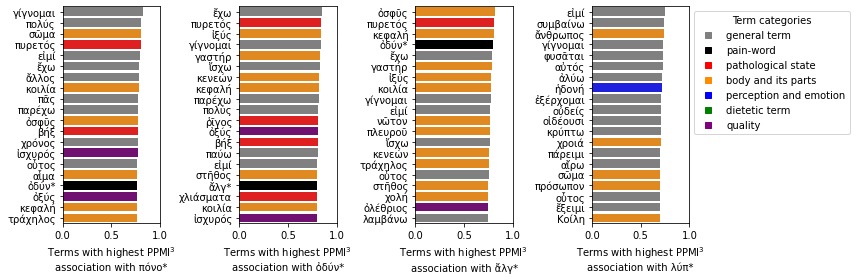

In [44]:
# read manually coded colors
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))

# manually define category-color pairs
cat_colors_dict = {'general term': 'gray',
 'pain-word': 'black',
 'pathological state': 'red',
 'body and its parts': 'darkorange',
 'perception and emotion' : 'blue',
 'dietetic term': 'green',
 'quality': 'purple'}
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]
    
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(key_words, axs):
    xcol = keyterms_pmi_20_df[word + " PPMI3"]
    ycol = keyterms_pmi_20_df[word]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="Terms with highest PPMI$^3$ \nassociation with " + word)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(0, 1)
plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in cat_colors_dict.values()]
plt.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [1028]:
# sddk.write_file("public_data/PIA/ppmi3_painwords_without-diet.png", fig, conf)

A file with the same name ("ppmi3_painwords.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/ppmi3_painwords.png"


# Tructated SVD


In [45]:
# takes some time, because of the high number of iterations
svd = TruncatedSVD(n_components=250, random_state=1, n_iter=200)
pmi_svd = svd.fit_transform(pmi_matrix_norm_df)

In [46]:
pmi_svd_df = pd.DataFrame(pmi_svd, index=vocabulary)
pmi_svd_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
εἰμί,22.824386,-1.057754,13.013820,1.379419,0.108526,1.012134,-0.290659,3.089576,-0.043262,-1.646800,...,0.895568,-0.010458,0.392348,-0.347745,-0.299986,-0.403512,0.076408,0.347677,-0.270403,0.110212
γίγνομαι,21.649313,-2.437028,11.738822,0.001422,-0.536020,0.910134,-1.125696,2.790816,0.531050,-1.230086,...,0.012551,-0.322952,-0.810583,0.360046,0.493026,0.293012,-0.063420,0.188869,0.189806,-0.382323
οὗτος,21.017839,-0.106354,10.946618,2.033437,0.104791,1.008982,-0.467190,2.560958,0.118249,-1.162595,...,0.055921,0.193688,0.351873,0.295109,-0.311834,0.127553,0.841682,-0.234598,0.133632,-0.059645
πολύς,21.347083,-0.939216,11.285671,0.908565,-0.774434,1.324085,0.015975,2.125536,0.209187,-0.969111,...,-0.822914,-0.497494,0.718548,-0.725966,0.379534,-0.512129,0.379929,-0.602155,-0.050990,0.126530
ἔχω,20.893065,-0.659891,10.610805,0.326404,0.173242,0.621295,0.115525,1.673240,-0.749278,-0.930807,...,0.342834,-0.553514,0.047654,0.078451,-0.224456,0.590994,0.415996,0.605466,-0.807052,-0.226122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,1.013077,-0.310786,-0.919740,0.225514,-0.071526,0.247065,0.082143,0.310367,-0.018758,-0.042198,...,0.033099,0.096398,0.178507,-0.095788,0.014835,-0.087567,-0.133605,0.238400,0.154285,0.102909
διαχωρέῃ,0.963873,-0.004329,-0.576990,-0.460043,-0.414983,0.334939,-0.272492,0.162943,0.213497,0.218441,...,-0.101467,0.066830,-0.030920,-0.116858,0.203945,-0.203623,0.060463,-0.039762,0.085735,0.111529
δεόμενον,1.288972,-0.396904,-0.793268,0.505707,-0.083251,0.059641,-0.023080,0.062624,-0.101112,-0.242380,...,0.077168,-0.038902,0.185430,-0.143573,-0.016434,0.113819,-0.053125,-0.261942,0.293404,-0.211231
γυμνός,0.701159,-0.129659,-0.571770,-0.051909,0.280935,0.167823,-0.001137,-0.017008,-0.168256,0.040354,...,0.237792,0.009588,-0.043553,0.164203,0.018386,-0.011057,0.111392,-0.075378,0.056997,0.130948


In [47]:
pmi_svd_cos = pd.DataFrame(cosine_similarity(pmi_svd_df.to_numpy()), columns=vocabulary, index=vocabulary)
pmi_svd_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,1.000000,0.965552,0.962926,0.965274,0.954082,0.903833,0.864155,0.858461,0.832914,0.872594,...,0.204643,0.253245,0.224475,0.229072,0.192155,0.215170,0.215891,0.250386,0.185695,0.209158
γίγνομαι,0.965552,1.000000,0.930656,0.951238,0.924340,0.879565,0.829145,0.857901,0.791814,0.847668,...,0.197759,0.245546,0.247547,0.215852,0.215380,0.203344,0.222518,0.248747,0.173312,0.213884
οὗτος,0.962926,0.930656,1.000000,0.943434,0.915822,0.893255,0.863346,0.828133,0.813375,0.854074,...,0.188052,0.232221,0.228645,0.222246,0.175793,0.230050,0.208091,0.252571,0.169169,0.223042
πολύς,0.965274,0.951238,0.943434,1.000000,0.923616,0.890136,0.842541,0.848824,0.796428,0.853868,...,0.188080,0.228056,0.256699,0.230504,0.199789,0.220429,0.220580,0.254958,0.178845,0.226811
ἔχω,0.954082,0.924340,0.915822,0.923616,1.000000,0.871980,0.842353,0.847267,0.828208,0.859956,...,0.178971,0.259210,0.248585,0.250437,0.185687,0.222391,0.223079,0.232173,0.205225,0.206719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.215170,0.203344,0.230050,0.220429,0.222391,0.244531,0.233311,0.268416,0.233918,0.215891,...,0.260424,0.285600,0.230370,0.266922,0.058324,1.000000,0.296818,0.291467,0.221717,0.271870
διαχωρέῃ,0.215891,0.222518,0.208091,0.220580,0.223079,0.227620,0.215224,0.203113,0.232020,0.223927,...,0.132658,0.185612,0.149419,0.143176,0.050012,0.296818,1.000000,0.173279,0.113272,0.225516
δεόμενον,0.250386,0.248747,0.252571,0.254958,0.232173,0.245325,0.255731,0.277518,0.281247,0.253389,...,0.245812,0.205219,0.245481,0.254420,0.124514,0.291467,0.173279,1.000000,0.146396,0.211915
γυμνός,0.185695,0.173312,0.169169,0.178845,0.205225,0.229289,0.166252,0.190149,0.224734,0.200320,...,0.208014,0.413012,0.275087,0.250773,0.020686,0.221717,0.113272,0.146396,1.000000,0.132587


In [48]:
pmi_svd_cos_pain = {}
for key_word in key_words: 
    ordered_df = pmi_svd_cos.sort_values(key_word, ascending=False)
    pmi_svd_cos_pain[key_word + " word"] = ordered_df.index.tolist()[1:21]
    pmi_svd_cos_pain[key_word + " cos.sim."] = ordered_df[key_word].tolist()[1:21]

In [49]:
pmi_svd_cos_pain_df = pd.DataFrame(pmi_svd_cos_pain)
pmi_svd_cos_pain_df

,πόνο* word,πόνο* cos.sim.,ὀδύν* word,ὀδύν* cos.sim.,ἄλγ* word,ἄλγ* cos.sim.,λύπ* word,λύπ* cos.sim.
0,πολύς,0.779542,πυρετός,0.811128,ὀδύν*,0.752757,ἐρωτάω,0.598816
1,πυρετός,0.775329,ἔχω,0.804831,πυρετός,0.725428,χροιά,0.597040
2,ἔχω,0.764513,γίγνομαι,0.804477,ὀξύς,0.705719,συμβαίνω,0.589135
3,γίγνομαι,0.764432,πολύς,0.788349,ῥῖγος,0.705272,ἀνίστημι,0.584459
4,εἰμί,0.762932,εἰμί,0.787775,γαστήρ,0.703798,ἐξέρχομαι,0.584007
5,ἄλλος,0.749057,οὗτος,0.776014,κεφαλή,0.702596,αἴρω,0.571925
6,σῶμα,0.743051,κεφαλή,0.771723,ἔχω,0.701402,ὅρος,0.571312
7,κοιλία,0.739714,γαστήρ,0.759713,πόνο*,0.699681,σπλάγχνον,0.571284
8,ὀδύν*,0.734700,κοιλία,0.755252,γίγνομαι,0.691985,πότος,0.571230
9,οὗτος,0.726372,ἄλγ*,0.752757,πολύς,0.682977,βληχρός,0.568656


In [50]:
pmi_svd_cos_pain_df = pd.DataFrame(pmi_svd_cos_pain)
pmi_svd_cos_pain_df

,πόνο* word,πόνο* cos.sim.,ὀδύν* word,ὀδύν* cos.sim.,ἄλγ* word,ἄλγ* cos.sim.,λύπ* word,λύπ* cos.sim.
0,πολύς,0.779542,πυρετός,0.811128,ὀδύν*,0.752757,ἐρωτάω,0.598816
1,πυρετός,0.775329,ἔχω,0.804831,πυρετός,0.725428,χροιά,0.597040
2,ἔχω,0.764513,γίγνομαι,0.804477,ὀξύς,0.705719,συμβαίνω,0.589135
3,γίγνομαι,0.764432,πολύς,0.788349,ῥῖγος,0.705272,ἀνίστημι,0.584459
4,εἰμί,0.762932,εἰμί,0.787775,γαστήρ,0.703798,ἐξέρχομαι,0.584007
5,ἄλλος,0.749057,οὗτος,0.776014,κεφαλή,0.702596,αἴρω,0.571925
6,σῶμα,0.743051,κεφαλή,0.771723,ἔχω,0.701402,ὅρος,0.571312
7,κοιλία,0.739714,γαστήρ,0.759713,πόνο*,0.699681,σπλάγχνον,0.571284
8,ὀδύν*,0.734700,κοιλία,0.755252,γίγνομαι,0.691985,πότος,0.571230
9,οὗτος,0.726372,ἄλγ*,0.752757,πολύς,0.682977,βληχρός,0.568656


In [55]:
words = []
for key_word in key_words:
    words.extend(pmi_svd_cos_pain_df[key_word + " word"].tolist())
ppmi3svd_unique_words = list(set(words))
len(ppmi3svd_unique_words)

50

In [56]:
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))

In [57]:
for term in ppmi3svd_unique_words:
    if term not in terms_by_cat_dict.keys():
        print(morpheus_by_lemma[term])

In [58]:
term_cats = list(set(terms_by_cat_dict.values()))
term_cats

['quality',
 'general term',
 'dietetic term',
 'pathological state',
 'pain-word',
 'perception and emotion',
 'body and its parts']

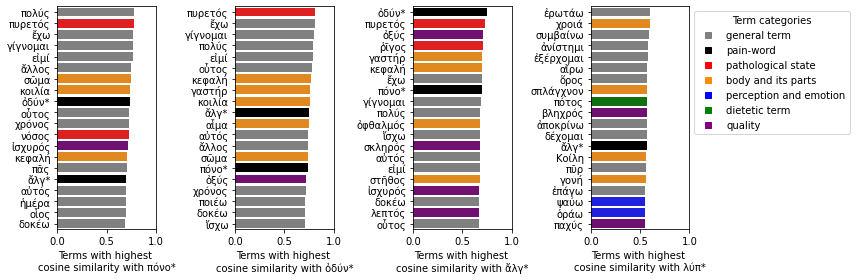

In [59]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

# manually define category-color pairs
cat_colors_dict = {'general term': 'gray',
 'pain-word': 'black',
 'pathological state': 'red',
 'body and its parts': 'darkorange',
 'perception and emotion' : 'blue',
 'dietetic term': 'green',
 'quality': 'purple'}
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]

for word, ax in zip(key_words, axs):
    xcol = pmi_svd_cos_pain_df[word + " cos.sim."]
    ycol = pmi_svd_cos_pain_df[word + " word"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="Terms with highest \ncosine similarity with " + word)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(0, 1)
plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in cat_colors_dict.values()]
plt.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

#plt.title("Terms with highest cosine similarity with the pain words ($PPMI^3$ based vectors)", loc="right")

In [126]:
sddk.write_file("public_data/PIA/pmmi3_svd.png", fig, conf)

A file with the same name ("pmmi3_svd.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/pmmi3_svd.png"


In [99]:
# set_with_dataframe(PIA_overview.add_worksheet("pmi_svd_cos_pain", 1, 1), pmi_svd_cos_pain_df)

In [60]:
def translate(term):
    try: return morpheus_by_lemma[term][0]["s"]
    except: return ""
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_df["translation"] = terms_by_cat_df["term"].apply(translate)
terms_by_cat_df

,term,term_category,translation
0,πρότερος,general term,prae.
1,ψυχρός,quality,"cold, chill"
2,λαμβάνω,general term,to take
3,κεφαλή,body and its parts,the head
4,ἰσχυρός,quality,"strong, mighty"
...,...,...,...
110,σκέλος,body and its parts,the leg
111,ἄσις,body and its parts,"slime, mud"
112,ἔξειμι,general term,
113,δέχομαι,general term,"to take, accept, receive"


In [137]:
set_with_dataframe(PIA_overview.add_worksheet("terms_tmp", 1, 1), terms_by_cat_df)

# PMI SVD cos plotting distances

In [61]:
pmi_svd_cos = pmi_svd_cos.round(5)
pmi_svd_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,1.00000,0.96555,0.96293,0.96527,0.95408,0.90383,0.86415,0.85846,0.83291,0.87259,...,0.20464,0.25324,0.22448,0.22907,0.19215,0.21517,0.21589,0.25039,0.18570,0.20916
γίγνομαι,0.96555,1.00000,0.93066,0.95124,0.92434,0.87957,0.82915,0.85790,0.79181,0.84767,...,0.19776,0.24555,0.24755,0.21585,0.21538,0.20334,0.22252,0.24875,0.17331,0.21388
οὗτος,0.96293,0.93066,1.00000,0.94343,0.91582,0.89325,0.86335,0.82813,0.81338,0.85407,...,0.18805,0.23222,0.22864,0.22225,0.17579,0.23005,0.20809,0.25257,0.16917,0.22304
πολύς,0.96527,0.95124,0.94343,1.00000,0.92362,0.89014,0.84254,0.84882,0.79643,0.85387,...,0.18808,0.22806,0.25670,0.23050,0.19979,0.22043,0.22058,0.25496,0.17885,0.22681
ἔχω,0.95408,0.92434,0.91582,0.92362,1.00000,0.87198,0.84235,0.84727,0.82821,0.85996,...,0.17897,0.25921,0.24859,0.25044,0.18569,0.22239,0.22308,0.23217,0.20523,0.20672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.21517,0.20334,0.23005,0.22043,0.22239,0.24453,0.23331,0.26842,0.23392,0.21589,...,0.26042,0.28560,0.23037,0.26692,0.05832,1.00000,0.29682,0.29147,0.22172,0.27187
διαχωρέῃ,0.21589,0.22252,0.20809,0.22058,0.22308,0.22762,0.21522,0.20311,0.23202,0.22393,...,0.13266,0.18561,0.14942,0.14318,0.05001,0.29682,1.00000,0.17328,0.11327,0.22552
δεόμενον,0.25039,0.24875,0.25257,0.25496,0.23217,0.24533,0.25573,0.27752,0.28125,0.25339,...,0.24581,0.20522,0.24548,0.25442,0.12451,0.29147,0.17328,1.00000,0.14640,0.21192
γυμνός,0.18570,0.17331,0.16917,0.17885,0.20523,0.22929,0.16625,0.19015,0.22473,0.20032,...,0.20801,0.41301,0.27509,0.25077,0.02069,0.22172,0.11327,0.14640,1.00000,0.13259


In [62]:
# inverse similarity to distance
pmi_svd_cos_dist = (1 - pmi_svd_cos) / 1
pmi_svd_cos_dist.round(5)

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,ποιέω,σῶμα,χρή,αὐτός,...,κωφός,κλίνω,καταπαύω,καταπίπτω,θόρυβος,εὐεξίη,διαχωρέῃ,δεόμενον,γυμνός,βῆχας
εἰμί,0.00000,0.03445,0.03707,0.03473,0.04592,0.09617,0.13585,0.14154,0.16709,0.12741,...,0.79536,0.74676,0.77552,0.77093,0.80785,0.78483,0.78411,0.74961,0.81430,0.79084
γίγνομαι,0.03445,0.00000,0.06934,0.04876,0.07566,0.12043,0.17085,0.14210,0.20819,0.15233,...,0.80224,0.75445,0.75245,0.78415,0.78462,0.79666,0.77748,0.75125,0.82669,0.78612
οὗτος,0.03707,0.06934,0.00000,0.05657,0.08418,0.10675,0.13665,0.17187,0.18662,0.14593,...,0.81195,0.76778,0.77136,0.77775,0.82421,0.76995,0.79191,0.74743,0.83083,0.77696
πολύς,0.03473,0.04876,0.05657,0.00000,0.07638,0.10986,0.15746,0.15118,0.20357,0.14613,...,0.81192,0.77194,0.74330,0.76950,0.80021,0.77957,0.77942,0.74504,0.82115,0.77319
ἔχω,0.04592,0.07566,0.08418,0.07638,0.00000,0.12802,0.15765,0.15273,0.17179,0.14004,...,0.82103,0.74079,0.75141,0.74956,0.81431,0.77761,0.77692,0.76783,0.79477,0.79328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
εὐεξίη,0.78483,0.79666,0.76995,0.77957,0.77761,0.75547,0.76669,0.73158,0.76608,0.78411,...,0.73958,0.71440,0.76963,0.73308,0.94168,0.00000,0.70318,0.70853,0.77828,0.72813
διαχωρέῃ,0.78411,0.77748,0.79191,0.77942,0.77692,0.77238,0.78478,0.79689,0.76798,0.77607,...,0.86734,0.81439,0.85058,0.85682,0.94999,0.70318,0.00000,0.82672,0.88673,0.77448
δεόμενον,0.74961,0.75125,0.74743,0.74504,0.76783,0.75467,0.74427,0.72248,0.71875,0.74661,...,0.75419,0.79478,0.75452,0.74558,0.87549,0.70853,0.82672,0.00000,0.85360,0.78808
γυμνός,0.81430,0.82669,0.83083,0.82115,0.79477,0.77071,0.83375,0.80985,0.77527,0.79968,...,0.79199,0.58699,0.72491,0.74923,0.97931,0.77828,0.88673,0.85360,0.00000,0.86741


In [67]:
# tSNE to project all words into a 2-dimensional space
data = pmi_svd_cos_dist

tsne = TSNE(n_components=2, random_state=1, perplexity=18, metric='precomputed', n_iter=5000) # dissimilarity="precomputed",

pos = tsne.fit_transform(data) # project all points into space
xs, ys = pos[:, 0], pos[:, 1]

# extract minimal and maximal values
minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]

# normalize on scale from 0 to 1
xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
ys = (ys - minmax[2]) / (minmax[3] - minmax[2])

In [68]:
pain_xs, pain_ys = [], []
for x, y, word in zip(xs, ys, data.index):
    if word in key_words:
        pain_xs.append(x)
        pain_ys.append(y)
        
border = 0.03
xlim = np.min(pain_xs) - border, np.max(pain_xs) + border
ylim = np.min(pain_ys) - border, np.max(pain_ys) + border

In [69]:
# choose words to plot:
# tfidf words
tfidf_unique_words = ['ἄνθρωπος', 'σιτίον', 'πυρετός', 'ὀξύς', 'σῖτος', 'ὀδύν*', 'στῆθος', 'ἐσθίω', 'πόνο*', 'πλευροῦ', 'εἰμί', 'κεφαλή', 'ἐξέρχομαι', 'λαμβάνω', 'γαστήρ', 'σῶμα', 'μήτρα', 'ἀειδής', 'παρέχω', 'συμβαίνω', 'ἐπίνοσον', 'παύω', 'τράχηλος', 'ἡμέρα', 'γίγνομαι', 'οὗτος', 'χρόνος', 'ἔχω', 'βήξ', 'αἷμα', 'μεμιγμένα', 'πᾶς', 'ἴσχω', 'χολή', 'ὀσφῦς', 'ὀλίγος', 'σάρξ', 'ἰξύς', 'πολύς', 'προσήκω', 'ἄλγ*', 'ἰσχυρός', 'αὐτός', 'οὐδείς', 'ῥῖγος', 'κοιλία', 'νειαίρην', 'ἄλλος', 'κενεών']

words_to_plot = list(set(ppmi3_unique_words + ppmi3_unique_words + tfidf_unique_words))
len(words_to_plot)

63

Text(0.5, 0.98, 'PPMI$^3_{SVD}$ embeddings - tSNE projection')

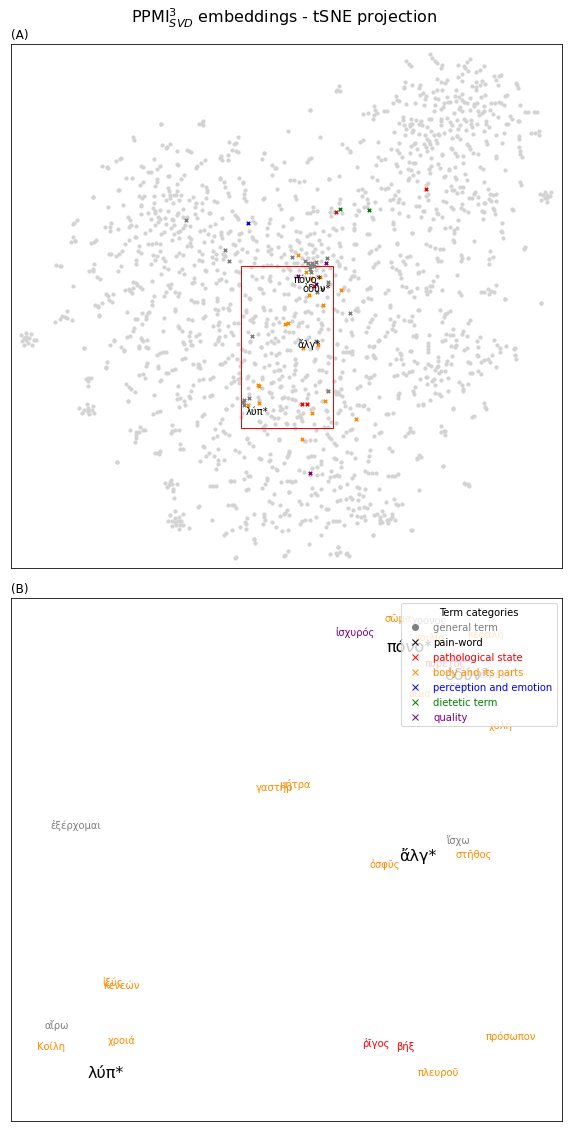

In [70]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(8, 16), tight_layout=True)

# SUBPLOT "(A)"
for x, y, word in zip(xs, ys, data.index):
    if word not in key_words:
        if word in words_to_plot:
            ax1.scatter(x, y, s=12, marker="x", color=terms_by_col_dict[word], zorder=2)# c=np.array([terms_by_col_dict[word]]))
            #ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=1)
        else:
            ax1.scatter(x, y, s=10, color="lightgrey", zorder=1)# c=np.array([terms_by_col_dict[word]]))
    if word in key_words:
        ax1.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
        ax1.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=3)
    
# RECTANGLE
rect = patches.Rectangle((xlim[0],ylim[0]),xlim[1] - xlim[0], ylim[1] - ylim[0],linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(-0.02, 1.02)

ax1.set_title("(A)", loc="left")

# SUBPLOT "(B)"
for x, y, word in zip(xs, ys, data.index):
    if word in words_to_plot:
        if word not in key_words:
            if (xlim[1] - 0.01 > x > xlim[0] + 0.01) and (ylim[1] - 0.01 > y > ylim[0] + 0.01):            
                ax2.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
                ax2.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=1)
    if word in key_words:
        ax2.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
        ax2.text(x, y-0.003, word, horizontalalignment='center', fontsize=16, color=terms_by_col_dict[word], zorder=2)
    
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

ax2.set_title("(B)", loc="left")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="x", linestyle="") for color in cat_colors_dict.values()]
markers[0] = plt.Line2D([0,0],[0,0],color="gray", marker="o", linestyle="")
plt.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper right', labelcolor='linecolor')

fig.suptitle("PPMI$^3_{SVD}$ embeddings - tSNE projection", fontsize=16)

In [172]:
#sddk.write_file("public_data/PIA/pmmi3_svd_embdeddings1.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/pmmi3_svd_embdeddings1.png"


In [71]:
rectangle_words = ['πόνο*', 'ἄλγ*', 'λύπ*']
redge = 0.08 # rectangle edge

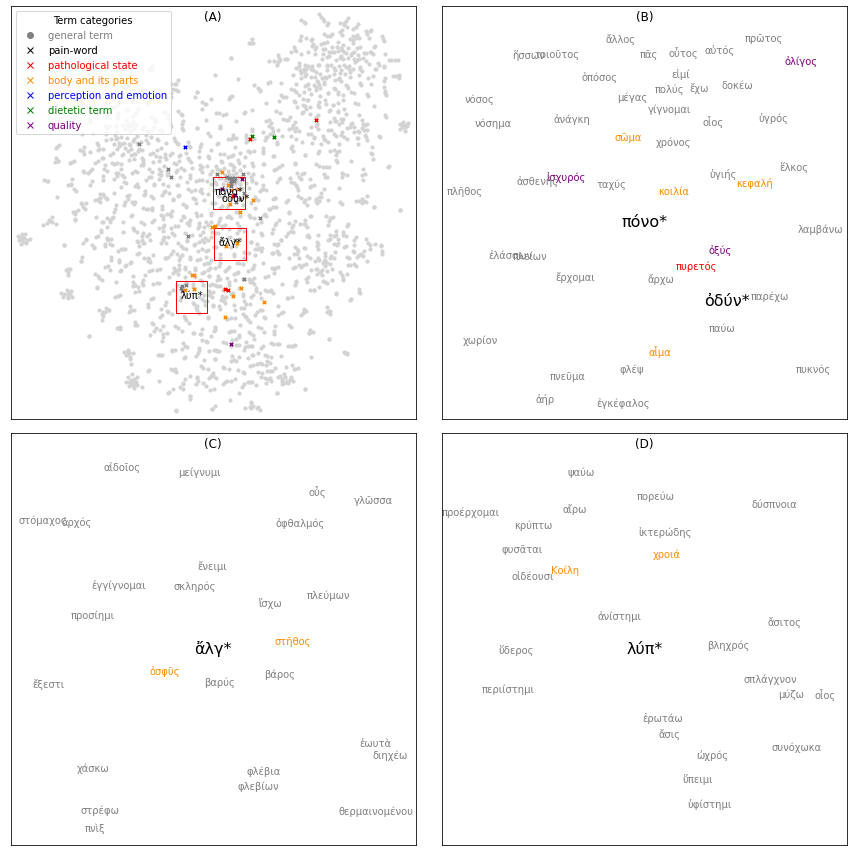

In [74]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(12, 12), tight_layout=True)

# SUBPLOT "(A)"
rectangle_words_xy = {}
for x, y, word in zip(xs, ys, data.index):
    if word not in key_words:
        if word in words_to_plot:
            ax1.scatter(x, y, s=12, marker="x", color=terms_by_col_dict[word], zorder=2)# c=np.array([terms_by_col_dict[word]]))
            #ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=1)
        else:
            ax1.scatter(x, y, s=10, color="lightgrey", zorder=1)# c=np.array([terms_by_col_dict[word]]))
    # PAIN WORDS
    if word in key_words:
        ax1.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
        ax1.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=3)
    # RECTANGLES
    if word in rectangle_words:
        rect = patches.Rectangle((x - redge/2,y - redge/2), redge, redge, linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)
        rectangle_words_xy[word] = [x,y]

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(-0.02, 1.02)

ax1.set_title("(A)", y=1, pad=-14)

markers = [plt.Line2D([0,0],[0,0],color=color, marker="x", linestyle="") for color in cat_colors_dict.values()]
markers[0] = plt.Line2D([0,0],[0,0],color="gray", marker="o", linestyle="")
ax1.legend(markers, cat_colors_dict.keys(), numpoints=1,  title="Term categories", bbox_to_anchor=(0, 1), loc='upper left', labelcolor='linecolor')

# RECTANGLES
titles = ["(B)", "(C)", "(D)"]
for ax, rec_word, title in zip([ax2, ax3, ax4], rectangle_words, titles):
    xy = rectangle_words_xy[rec_word]
    for x, y, word in zip(xs, ys, data.index):
        if (xy[0] + redge/2 > x > xy[0] - redge/2) and (xy[1] + redge/2 > y > xy[1] - redge/2):
            if word in key_words:
                ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
                ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=16, color=terms_by_col_dict[word], zorder=2)
            else: 
                if word in words_to_plot:
                    ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
                    ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=1)
                else:
                    ax.scatter(x, y, s=10, color="white", zorder=1)# c=np.array([terms_by_col_dict[word]]))
                    ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color="gray", zorder=1)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim(xy[0] - redge/1.8, xy[0] + redge/1.8)
    ax.set_ylim(xy[1] - redge/1.8, xy[1] + redge/1.8)
    ax.set_title(title, y=1, pad=-14)

#fig.suptitle("PPMI$^3_{SVD}$ embeddings - tSNE projection", fontsize=16)

In [221]:
#sddk.write_file("public_data/PIA/pmmi3_svd_embdeddings4.png", fig, conf)

A file with the same name ("pmmi3_svd_embdeddings4.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/pmmi3_svd_embdeddings4.png"


In [222]:
rectangle_words_xy

{'πόνο*': [0.50479877, 0.442536],
 'ἄλγ*': [0.54020286, 0.38290718],
 'λύπ*': [0.7144038, 0.09840513]}

In [226]:
redge = redge * 1.5

Text(0.5, 1, '(D)')

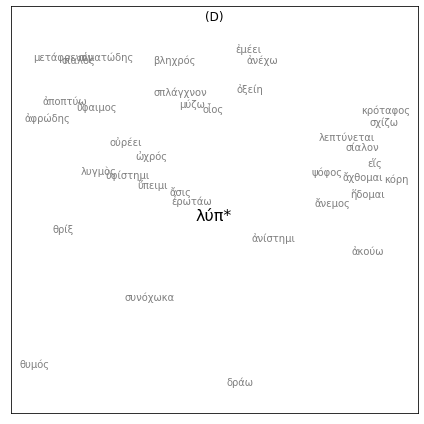

In [225]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

xy = rectangle_words_xy["λύπ*"]
for x, y, word in zip(xs, ys, data.index):
    if (xy[0] + redge/2 > x > xy[0] - redge/2) and (xy[1] + redge/2 > y > xy[1] - redge/2):
        if word in key_words:
            ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
            ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=16, color=terms_by_col_dict[word], zorder=2)
        else: 
            if word in words_to_plot:
                ax.scatter(x, y, color="white")# c=np.array([terms_by_col_dict[word]]))
                ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color=terms_by_col_dict[word], zorder=1)
            else:
                ax.scatter(x, y, s=10, color="white", zorder=1)# c=np.array([terms_by_col_dict[word]]))
                ax.text(x, y-0.003, word, horizontalalignment='center', fontsize=10, color="gray", zorder=1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(xy[0] - redge/1.8, xy[0] + redge/1.8)
ax.set_ylim(xy[1] - redge/1.8, xy[1] + redge/1.8)
ax.set_title(title, y=1, pad=-14)



In [ ]:
for x, y, word in zip(xs, ys, data.index):
    if word in terms_by_cat_dict.keys():
        ax.scatter(x, y, c=np.array([color]))
        ax.text(x, y + 0.01, word, horizontalalignment='center', fontsize=10)


ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(- 0.1, 1.1)
title = "Corpus hippocraticum: Document distances based on vocabulary\n(work categories by Jouanna 1999)"
ax.set_title(title)


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", fontsize=10, bbox_to_anchor=(1,1), loc="upper left")

In [1112]:
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
terms_by_cat_dict.keys()

{'πρότερος': 'temporal quality',
 'ψυχρός': 'quality',
 'λαμβάνω': 'general term',
 'κεφαλή': 'bodily part or constituent',
 'ἰσχυρός': 'quality',
 'ἄνθρωπος': 'bodily part or constituent',
 'χολή': 'bodily part or constituent',
 'ὁπόσος': 'quality',
 'ἄλγ*': 'pain-word',
 'τρίτος': 'temporal quality',
 'πᾶς': 'general term',
 'πλείων': 'general term',
 'σάρξ': 'bodily part or constituent',
 'συμβαίνω': 'general term',
 'θερμός': 'quality',
 'μαλλός': 'general term',
 'ἡμέρα': 'temporal quality',
 'πόνο*': 'pain-word',
 'ὀδύν*': 'pain-word',
 'κοιλία': 'bodily part or constituent',
 'εἶμι': 'general term',
 'ποιέω': 'general term',
 'γίγνομαι': 'general term',
 'ἔχω': 'general term',
 'καθίημι': 'general term',
 'δοκέω': 'general term',
 'δίδωμι': 'general term',
 'ὀξύς': 'quality',
 'πολύς': 'general term',
 'μήτρα': 'bodily part or constituent',
 'ἰξύς': 'bodily part or constituent',
 'κενεών': 'bodily part or constituent',
 'χρόνος': 'temporal quality',
 'σιτίον': 'pathological stat

In [1108]:
terms_by_col_dict["γίγνομαι"]

'gray'

# Backup: Previous experiments with LSA

In [892]:
svd = TruncatedSVD(n_components=250)
lsa = svd.fit_transform(tfidf)
lsa_doc = pd.DataFrame(lsa) #, columns=vocabulary)
lsa_doc

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.291092,0.120812,-0.011414,-0.045221,0.087048,-0.015248,0.134973,0.037312,0.040419,-0.008096,...,-0.023577,0.023873,0.017753,-0.026195,0.012706,0.029686,-0.015625,-0.034971,-0.007640,-0.007286
1,0.113945,-0.048341,0.013215,-0.068549,0.199092,0.277817,0.038364,-0.080837,-0.007310,-0.050582,...,0.005202,0.005137,0.004956,0.000223,0.006238,-0.005648,-0.003812,-0.004576,0.005733,-0.003043
2,0.278826,0.343216,-0.054982,-0.059967,-0.113581,0.003020,0.013958,0.001845,0.020055,-0.038230,...,-0.006006,-0.028921,-0.005711,0.055508,0.012969,-0.002231,-0.004746,-0.062788,0.018479,-0.036495
3,0.178850,-0.017742,0.019273,-0.042593,0.297982,-0.070750,0.074128,-0.163608,-0.043452,-0.087134,...,-0.053331,-0.026377,-0.021582,-0.020280,-0.024655,-0.033270,0.029185,0.019736,-0.016080,0.044814
4,0.066580,-0.000201,-0.002682,0.012326,0.013823,-0.011123,0.012705,0.024484,0.029276,-0.004064,...,-0.000818,0.008670,-0.014765,-0.025303,-0.008954,0.000089,0.012837,-0.018779,0.017352,-0.015500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24451,0.075155,-0.018564,-0.005475,0.073267,0.005832,-0.018919,0.031640,-0.021884,0.068928,-0.067545,...,0.002607,-0.001323,0.003396,0.002406,0.003437,0.003704,0.000441,0.001182,0.002269,-0.001387
24452,0.296445,0.058825,-0.050300,0.135022,0.033343,0.169435,0.042056,0.001736,0.115289,-0.071581,...,-0.002363,0.007474,0.010698,-0.012415,0.003211,0.005329,0.006494,0.007056,-0.009217,-0.000316
24453,0.065155,0.040187,0.399040,0.056255,-0.012848,-0.014455,0.004877,-0.012601,0.004090,-0.011182,...,-0.016274,0.000194,-0.001512,-0.031107,-0.004968,-0.036236,0.006979,-0.010521,-0.037103,-0.038958
24454,0.158804,0.026910,-0.011339,-0.081714,-0.097286,-0.011491,-0.005095,-0.019178,0.002196,-0.016735,...,-0.005564,0.018009,0.014392,0.023937,0.042614,-0.010459,-0.002001,-0.021583,0.007948,0.015325


In [893]:
lsa_word = pd.DataFrame(svd.components_, columns=vocabulary).T #, columns=vocabulary)
lsa_word

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
εἰμί,0.481994,0.757178,-0.126295,-0.137315,-0.309753,0.076535,-0.036132,-0.094879,-0.061312,-0.068219,...,0.000771,-0.004147,-0.002766,0.005831,0.001313,0.001150,-0.002089,0.001149,-0.002744,0.000613
γίγνομαι,0.385735,-0.563874,0.033859,-0.456447,-0.465803,-0.095518,-0.077631,-0.051129,-0.078033,-0.144964,...,-0.001372,-0.001277,-0.008644,0.005807,-0.002493,-0.005655,0.002305,-0.002098,-0.001804,0.000854
οὗτος,0.386984,-0.237714,-0.155228,0.810529,-0.182356,0.086513,0.034810,-0.142527,-0.120311,0.049164,...,-0.006240,0.000887,-0.001492,0.000447,-0.000935,-0.000493,-0.002332,-0.004415,-0.004133,0.001817
πολύς,0.285897,-0.126532,0.034322,-0.172830,0.507344,0.706528,0.095685,-0.206553,-0.021490,-0.126551,...,0.002339,0.002850,-0.002082,0.001739,0.004876,-0.000140,0.003147,0.004958,0.005255,-0.001397
ἔχω,0.207923,-0.000684,-0.004842,0.029985,0.466058,-0.461504,-0.606931,-0.298151,-0.038327,-0.152027,...,-0.001579,0.001877,-0.003560,0.002272,-0.001240,0.000518,-0.001716,0.001732,0.003596,0.002983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἀποστέλλω,0.000777,0.000133,-0.000011,0.000077,0.000478,-0.000402,0.000665,0.001117,0.002575,0.000311,...,0.000616,0.000805,-0.000060,0.000608,0.001988,0.000368,-0.002334,0.000241,-0.000358,0.000262
ἀποπέτομαι,0.000847,-0.000470,0.000101,-0.000828,0.000885,0.000547,-0.000191,0.000175,0.000523,0.002245,...,0.000160,0.001253,-0.001956,0.000276,-0.001185,0.000101,0.001000,-0.001763,-0.000187,-0.003585
ἀναΐσσει,0.000931,-0.000348,-0.000052,-0.000276,0.000590,-0.000395,-0.000286,-0.000444,0.000062,0.000790,...,-0.000180,0.002646,0.002093,0.000561,-0.000915,0.002104,-0.000686,-0.000118,-0.003367,0.000138
ἀλφίτοισι,0.000256,-0.000042,-0.000006,0.000152,0.000426,-0.000134,-0.000013,0.001373,-0.001122,-0.000171,...,-0.006492,-0.001816,0.000753,-0.000192,0.000098,0.000079,0.002321,-0.000988,-0.002716,0.004547


In [894]:
lsa_word_cos = pd.DataFrame(cosine_similarity(lsa_word.to_numpy()).round(5), columns=vocabulary, index=vocabulary)
lsa_word_cos

,εἰμί,γίγνομαι,οὗτος,πολύς,ἔχω,ἄλλος,σῶμα,ποιέω,χρή,αὐτός,...,ἀσθενείη,ἀπύρετος,ἀπόπατος,ἀπωθέω,ἀποτελευτάω,ἀποστέλλω,ἀποπέτομαι,ἀναΐσσει,ἀλφίτοισι,ἀλέα
εἰμί,1.00000,-0.00104,-0.00017,-0.00001,-0.00038,-0.00007,-0.00040,-0.00047,-0.00001,-0.00024,...,-0.01677,0.12176,-0.00279,-0.01038,-0.00766,-0.02031,-0.00872,-0.00344,-0.00716,-0.00451
γίγνομαι,-0.00104,1.00000,0.00009,-0.00037,-0.00082,-0.00029,0.00015,-0.00067,-0.00011,-0.00033,...,0.01665,-0.00345,0.06058,-0.00745,-0.00191,-0.00493,0.00815,0.01265,-0.00159,0.01221
οὗτος,-0.00017,0.00009,1.00000,-0.00015,0.00010,-0.00011,-0.00036,0.00030,0.00013,-0.00041,...,0.05083,-0.01183,0.05480,-0.00279,-0.00102,-0.02526,-0.01083,0.01191,0.00364,-0.02468
πολύς,-0.00001,-0.00037,-0.00015,1.00000,-0.00006,-0.00025,0.00008,-0.00024,0.00030,-0.00023,...,-0.02689,0.00808,-0.01440,-0.00393,-0.02168,-0.00753,0.01969,0.01149,-0.00295,0.05481
ἔχω,-0.00038,-0.00082,0.00010,-0.00006,1.00000,-0.00016,-0.00014,-0.00026,0.00014,-0.00011,...,0.02605,-0.02282,-0.01585,-0.00636,-0.01980,-0.01552,-0.00505,0.02694,-0.00575,-0.00837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἀποστέλλω,-0.02031,-0.00493,-0.02526,-0.00753,-0.01552,-0.01677,0.10073,0.10660,-0.00582,-0.03260,...,0.04649,-0.05125,-0.03915,-0.01910,-0.01652,1.00000,0.03234,0.02619,-0.07021,-0.02607
ἀποπέτομαι,-0.00872,0.00815,-0.01083,0.01969,-0.00505,-0.01221,0.05677,-0.01239,-0.00451,0.02542,...,0.02873,-0.06885,0.03287,-0.03588,0.17936,0.03234,1.00000,-0.02274,-0.04724,-0.03297
ἀναΐσσει,-0.00344,0.01265,0.01191,0.01149,0.02694,0.01458,0.01206,-0.01116,-0.01048,0.02127,...,0.01167,-0.09959,-0.07131,-0.00159,0.07013,0.02619,-0.02274,1.00000,0.00697,-0.05355
ἀλφίτοισι,-0.00716,-0.00159,0.00364,-0.00295,-0.00575,-0.00255,-0.00138,-0.01112,-0.00518,-0.00910,...,-0.07956,0.05779,-0.04862,-0.03991,-0.00792,-0.07021,-0.04724,0.00697,1.00000,0.03752


In [895]:
lsa_word_cos.sort_values("αἰτία", ascending=False)["αἰτία"][1:11]

ἐπιφέρω        0.39020
ἄδηλος         0.39018
αἴτιος         0.38436
ἀπόκρισις      0.38083
ὅδε            0.37467
πάθος          0.36896
θεός           0.35816
προειρημένα    0.34045
ἔργον          0.32858
καλός          0.32827
Name: αἰτία, dtype: float64

In [896]:
lsa_word_cos.sort_values("ὀδύν*", ascending=False)["ὀδύν*"][1:11]

ἀπαλλάσσηται    0.44013
χλιαίνειν       0.43666
πλευρίτιδι      0.42847
ὀξείη           0.37870
βρέγμα          0.33909
πλευροῦ         0.33297
νάρκη           0.30313
χλιάσματα       0.26793
φοιτάω          0.25847
ἄχθομαι         0.25395
Name: ὀδύν*, dtype: float64

In [897]:
lsa_word_cos.sort_values("πόνο*", ascending=False)["πόνο*"][1:11]

δύσπνοια       0.30235
ἀποπέτομαι     0.26514
γυμνάζω        0.21987
περισσῇσιν     0.21487
κουφίζω        0.21327
ὑποχονδρίῳ     0.20942
εἴλω           0.20890
ἀποτελευτάω    0.20226
σύμμετρος      0.19750
ἀφωνίαι        0.19118
Name: πόνο*, dtype: float64

In [898]:
def get_most_similar(model_df, target_term, number):
    all_similar = []
    for term in model_df.columns:
        similarity = (term, cosine_similarity([model_df[target_term],  model_df[term]])[0][1])
        all_similar.append(similarity)
    return sorted(all_similar, key=lambda number: number[1], reverse=True)[1:number]

In [899]:
key_words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [900]:
for word in key_words:
    if word in lsa_word_cos.index:
        print(word)

λύπ*
ἄλγ*
ὀδύν*
πόνο*
